# HPS Binary Classification Model

In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.feature_selection import RFECV, SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline
from joblib import parallel_backend
import xgboost as xgb
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
pd.set_option("display.max_columns",None)

In [ ]:
# Load and prepare data
filtered_df = pd.read_csv("/content/combinedphase4hps.csv")
X = filtered_df.drop(['Unnamed: 0','PWEIGHT', 'HWEIGHT', 'SCRAM', 'TWDAYS','TWDAYS_RESP','AHHLD_NUMPER','AHHLD_NUMKID','ABIRTH_YEAR','AEDUC','ARACE'], axis=1)
y = filtered_df['TWDAYS_RESP']

In [ ]:
X

,CYCLE,EST_ST,REGION,RHISPANIC,AHISPANIC,RRACE,EEDUC,MS,EGENID_BIRTH,AGENID_BIRTH,THHLD_NUMPER,THHLD_NUMKID,THHLD_NUMADLT,ACTVDUTY1,RECVDVACC,HADCOVIDRV,WRKLOSSRV,ANYWORK,KINDWORK,EXPNS_DIF,CURFOODSUF,FREEFOOD,ANXIOUS,WORRY,INTEREST,DOWN,PRIVHLTH,PUBHLTH,SEEING,HEARING,REMEMBERING,MOBILITY,SELFCARE,UNDERSTAND,TENURE,LIVQTRRV,ENERGY,HSE_TEMP,ENRGY_BILL,INCOME,PRICECHNG,PRICECONCRN,ND_DISPLACE,VETERAN1,SOCIAL1,SOCIAL2,SUPPORT1,SUPPORT2,SUPPORT3,AGE
0,1.0,36.0,1.0,1.0,2.0,1.0,4.0,1.0,2.0,2.0,2.0,0.0,2.0,1.0,1.0,1.0,2.0,1.0,4.0,3.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,4.0,4.0,4.0,6.0,1.0,3.0,2.0,1.0,1.0,4.0,4.0,2.0,1.0,55.0
1,1.0,34.0,1.0,1.0,2.0,1.0,6.0,5.0,2.0,2.0,2.0,0.0,2.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,3.0,2.0,2.0,4.0,4.0,4.0,4.0,2.0,2.0,1.0,2.0,3.0,3.0,2.0,1.0,28.0
2,1.0,36.0,1.0,2.0,2.0,1.0,5.0,1.0,1.0,2.0,4.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,3.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,4.0,4.0,4.0,6.0,1.0,1.0,2.0,1.0,5.0,3.0,2.0,2.0,2.0,49.0
3,1.0,34.0,1.0,1.0,2.0,1.0,7.0,1.0,1.0,2.0,4.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,4.0,4.0,4.0,8.0,1.0,3.0,2.0,1.0,2.0,4.0,4.0,2.0,1.0,50.0
4,1.0,36.0,1.0,1.0,2.0,1.0,6.0,1.0,1.0,2.0,2.0,0.0,2.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,6.0,4.0,4.0,4.0,7.0,1.0,1.0,2.0,1.0,2.0,4.0,3.0,2.0,2.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5660,9.0,34.0,1.0,1.0,2.0,3.0,5.0,1.0,1.0,2.0,4.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,4.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,4.0,4.0,4.0,8.0,1.0,1.0,2.0,1.0,2.0,3.0,1.0,2.0,4.0,49.0
5661,9.0,36.0,1.0,1.0,2.0,1.0,7.0,5.0,2.0,2.0,2.0,0.0,2.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,4.0,4.0,4.0,8.0,2.0,3.0,2.0,1.0,2.0,4.0,3.0,2.0,3.0,42.0
5662,9.0,36.0,1.0,1.0,2.0,1.0,7.0,1.0,2.0,2.0,2.0,0.0,2.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,4.0,4.0,4.0,8.0,1.0,2.0,2.0,1.0,3.0,4.0,4.0,1.0,1.0,33.0
5663,9.0,34.0,1.0,1.0,2.0,1.0,5.0,1.0,2.0,2.0,2.0,0.0,2.0,1.0,1.0,1.0,2.0,1.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,2.0,3.0,4.0,1.0,1.0,2.0,1.0,1.0,4.0,4.0,2.0,1.0,55.0


In [ ]:
# Convert labels from 1.0/2.0 to 0/1
y = (y == 2.0).astype(int)

In [ ]:
print("Performing initial feature selection...")
selector = SelectKBest(mutual_info_classif, k=50)  # Keep top 50 features
X_reduced = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support(indices=True)]
print("Top 50 features selected.")

Performing initial feature selection...
Top 50 features selected.


In [ ]:
# Create a DataFrame with reduced features for VIF and further steps
X = pd.DataFrame(X_reduced, columns=selected_features)

def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Calculate VIF for all features
print("Performing multicollinearity analysis...")
vif_data = calculate_vif(X)
print("VIF Results:")
print(vif_data)

# Drop features with high VIF (>10)
high_vif_features = vif_data[vif_data["VIF"] > 15]["Feature"].tolist()
print(f"Dropping features with high VIF: {high_vif_features}")
X = X.drop(columns=high_vif_features)

Performing multicollinearity analysis...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF Results:
          Feature       VIF
0           CYCLE  1.017447
1          EST_ST  1.177024
2          REGION  0.000000
3       RHISPANIC  1.042880
4       AHISPANIC  1.004881
5           RRACE  1.078979
6           EEDUC  1.222808
7              MS  1.753173
8    EGENID_BIRTH  1.112458
9    AGENID_BIRTH  1.011530
10   THHLD_NUMPER       inf
11   THHLD_NUMKID       inf
12  THHLD_NUMADLT       inf
13      ACTVDUTY1  0.000000
14      RECVDVACC  1.068647
15     HADCOVIDRV  1.041604
16      WRKLOSSRV  1.048995
17        ANYWORK  0.000000
18       KINDWORK  1.110101
19      EXPNS_DIF  2.112060
20     CURFOODSUF  1.742856
21       FREEFOOD  1.055199
22        ANXIOUS  2.953812
23          WORRY  2.912706
24       INTEREST  2.490250
25           DOWN  2.924415
26       PRIVHLTH  1.254752
27        PUBHLTH  1.224917
28         SEEING  1.174728
29        HEARING  1.139989
30    REMEMBERING  1.370348
31       MOBILITY  1.233866
32       SELFCARE  1.274685
33     UNDERSTAND  1.213315
34     

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Recursive Feature Elimination
print("Performing Recursive Feature Elimination...")
with parallel_backend('threading'):
    rf_model = RandomForestClassifier(random_state=42)
    rfecv = RFECV(estimator=rf_model, step=1, cv=5, scoring='accuracy', n_jobs=-1)
    rfecv.fit(X_train, y_train)

# Get selected features from RFE
rfe_selected_features = rfecv.support_
X_train_final = X_train.iloc[:, rfe_selected_features]
X_test_final = X_test.iloc[:, rfe_selected_features]

Performing Recursive Feature Elimination...


In [ ]:
# # Outlier Analysis
# print("Performing outlier analysis...")
# z_scores = np.abs((X_train_final - np.mean(X_train_final, axis=0)) / np.std(X_train_final, axis=0))
# threshold = 3
# non_outliers = (z_scores < threshold).all(axis=1)
# outlier_percentage = 100 * (1 - np.sum(non_outliers) / len(non_outliers))
# print(f"Percentage of outliers removed: {outlier_percentage:.2f}%")

# X_train_final = X_train_final[non_outliers]
# y_train = y_train[non_outliers]

In [ ]:
X_train_final

,CYCLE,EST_ST,RRACE,EEDUC,MS,EGENID_BIRTH,HADCOVIDRV,KINDWORK,EXPNS_DIF,CURFOODSUF,ANXIOUS,WORRY,INTEREST,DOWN,PUBHLTH,SEEING,REMEMBERING,TENURE,LIVQTRRV,ENERGY,INCOME,PRICECHNG,PRICECONCRN,SOCIAL1,SOCIAL2,SUPPORT1,SUPPORT2,SUPPORT3,AGE
2128,4.0,34.0,1.0,6.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,4.0,6.0,2.0,4.0,1.0,4.0,4.0,4.0,1.0,66.0
691,2.0,36.0,1.0,6.0,1.0,1.0,1.0,4.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,3.0,4.0,8.0,2.0,4.0,2.0,4.0,1.0,1.0,1.0,61.0
730,2.0,36.0,1.0,7.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,4.0,6.0,4.0,3.0,3.0,3.0,2.0,2.0,1.0,49.0
5443,9.0,36.0,1.0,6.0,1.0,2.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,3.0,6.0,4.0,7.0,1.0,3.0,3.0,4.0,1.0,1.0,1.0,54.0
1984,3.0,34.0,3.0,7.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,3.0,4.0,7.0,1.0,1.0,4.0,3.0,2.0,1.0,2.0,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4296,7.0,36.0,1.0,6.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,3.0,6.0,4.0,8.0,1.0,2.0,2.0,4.0,2.0,1.0,1.0,25.0
2763,5.0,34.0,1.0,6.0,1.0,2.0,1.0,2.0,4.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,3.0,3.0,6.0,4.0,7.0,1.0,1.0,2.0,3.0,2.0,1.0,1.0,34.0
3593,6.0,36.0,3.0,7.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,3.0,6.0,4.0,8.0,2.0,4.0,2.0,4.0,3.0,3.0,1.0,58.0
3277,5.0,34.0,1.0,7.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,4.0,8.0,1.0,2.0,1.0,5.0,3.0,2.0,1.0,42.0


In [ ]:
# Convert to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train_final, label=y_train)
dtest = xgb.DMatrix(X_test_final, label=y_test)

# Define XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'seed': 42
}

# Cross-validation
print("Performing cross-validation...")
num_round = 100
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_round,
    nfold=5,
    metrics=['auc', 'error'],
    early_stopping_rounds=20,
    verbose_eval=True
)

Performing cross-validation...
[0]	train-auc:0.72904+0.00717	train-error:0.13923+0.00246	test-auc:0.63914+0.03029	test-error:0.13923+0.00984
[1]	train-auc:0.74121+0.00650	train-error:0.13923+0.00246	test-auc:0.65050+0.03281	test-error:0.13923+0.00984
[2]	train-auc:0.74980+0.00536	train-error:0.13923+0.00246	test-auc:0.65789+0.03393	test-error:0.13923+0.00984
[3]	train-auc:0.75701+0.00727	train-error:0.13923+0.00246	test-auc:0.65717+0.03223	test-error:0.13923+0.00984
[4]	train-auc:0.76338+0.00684	train-error:0.13923+0.00246	test-auc:0.66330+0.03274	test-error:0.13923+0.00984
[5]	train-auc:0.76952+0.00707	train-error:0.13923+0.00246	test-auc:0.66412+0.03152	test-error:0.13923+0.00984
[6]	train-auc:0.77329+0.00713	train-error:0.13912+0.00241	test-auc:0.66570+0.02975	test-error:0.13923+0.00984
[7]	train-auc:0.77670+0.00816	train-error:0.13885+0.00223	test-auc:0.66564+0.02755	test-error:0.13923+0.00984
[8]	train-auc:0.78105+0.00848	train-error:0.13857+0.00220	test-auc:0.66675+0.02709	test-e

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:00:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	train-auc:0.79012+0.00617	train-error:0.13758+0.00225	test-auc:0.66581+0.02624	test-error:0.13945+0.00967
[11]	train-auc:0.79638+0.00740	train-error:0.13692+0.00228	test-auc:0.66725+0.02750	test-error:0.13945+0.00967
[12]	train-auc:0.79997+0.00864	train-error:0.13653+0.00261	test-auc:0.66868+0.02840	test-error:0.13967+0.00952
[13]	train-auc:0.80394+0.00838	train-error:0.13609+0.00258	test-auc:0.66558+0.02804	test-error:0.13967+0.00918
[14]	train-auc:0.80669+0.00852	train-error:0.13576+0.00253	test-auc:0.66478+0.02999	test-error:0.13967+0.00918
[15]	train-auc:0.81104+0.00836	train-error:0.13537+0.00250	test-auc:0.66511+0.03062	test-error:0.13945+0.00936
[16]	train-auc:0.81227+0.00863	train-error:0.13482+0.00277	test-auc:0.66637+0.03134	test-error:0.13923+0.00946
[17]	train-auc:0.81605+0.00882	train-error:0.13438+0.00338	test-auc:0.66839+0.03072	test-error:0.13945+0.00931
[18]	train-auc:0.81879+0.00957	train-error:0.13361+0.00334	test-auc:0.66744+0.02975	test-error:0.13967+0.00858
[


Cross-validation results:
Best AUC: 0.6704 (+/- 0.0262)
Best Error: 0.1379 (+/- 0.0084)

Training final model...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:07:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)



Model Performance Metrics:

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       975
           1       0.31      0.03      0.06       158

    accuracy                           0.86      1133
   macro avg       0.59      0.51      0.49      1133
weighted avg       0.79      0.86      0.80      1133


Confusion Matrix:
[[964  11]
 [153   5]]

ROC AUC Score: 0.6858

Top 10 Most Important Features:
         Feature  Importance
28           AGE       332.0
0          CYCLE       138.0
7       KINDWORK       136.0
20        INCOME       100.0
3          EEDUC        96.0
18      LIVQTRRV        82.0
25      SUPPORT1        77.0
27      SUPPORT3        76.0
24       SOCIAL2        75.0
8      EXPNS_DIF        72.0
5   EGENID_BIRTH        71.0
22   PRICECONCRN        63.0
9     CURFOODSUF        57.0
4             MS        56.0
19        ENERGY        56.0
23       SOCIAL1        55.0
26      SUPPORT2        54.0
1

<ipython-input-19-ee1406e2745e>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')


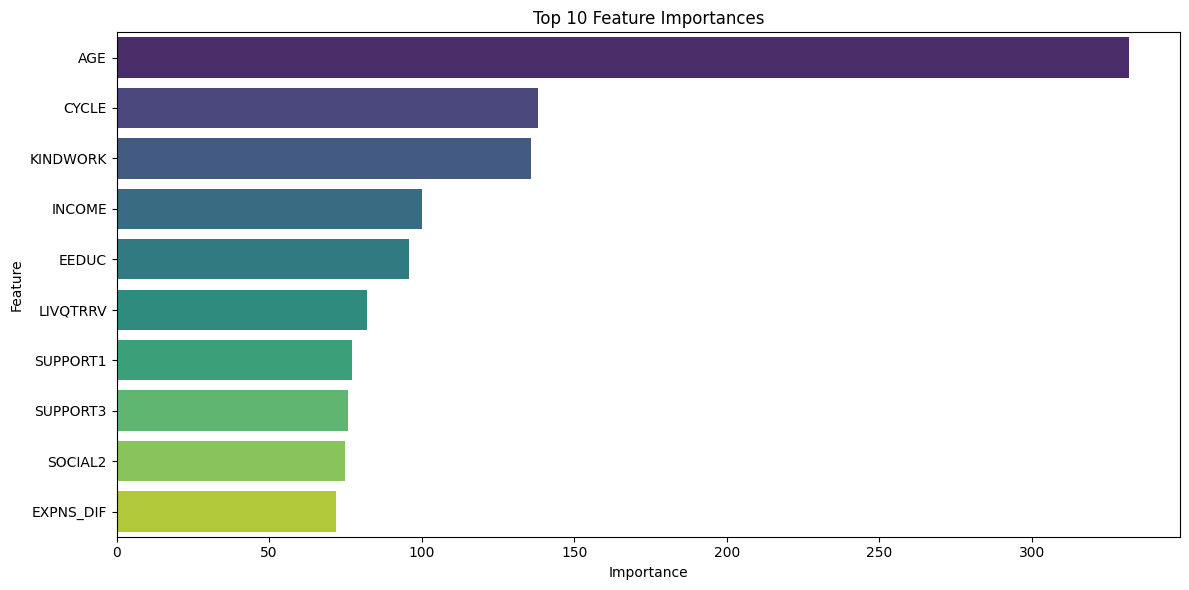

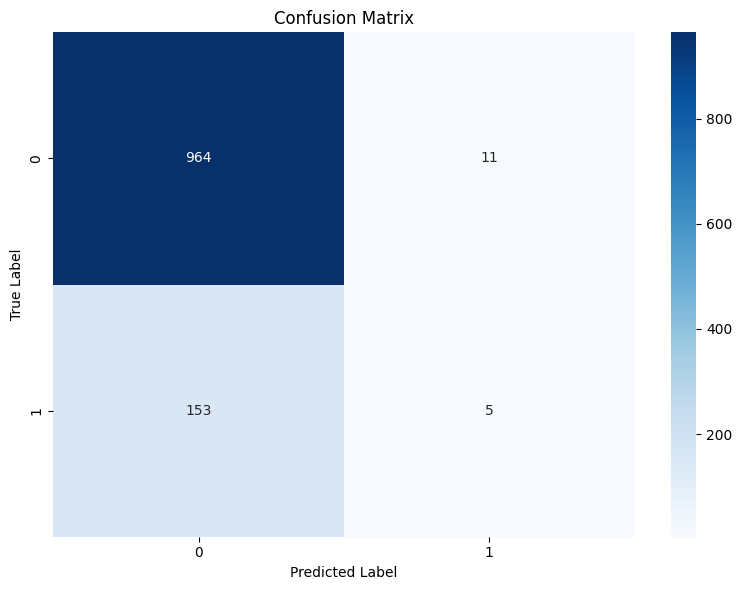

In [ ]:
# Print CV results
print("\nCross-validation results:")
print(f"Best AUC: {cv_results['test-auc-mean'].max():.4f} (+/- {cv_results['test-auc-std'].min():.4f})")
print(f"Best Error: {cv_results['test-error-mean'].min():.4f} (+/- {cv_results['test-error-std'].min():.4f})")

# Train final model
print("\nTraining final model...")
final_model = xgb.train(params, dtrain, num_round)

# Make predictions
y_pred = final_model.predict(dtest)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate and print metrics
print("\nModel Performance Metrics:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print(conf_matrix)

print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred):.4f}")

# Feature importance analysis
importance = final_model.get_score(importance_type='weight')
importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df)

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [ ]:
import statsmodels.api as sm
import shap
print("\nFitting Probit model for effect sizes and p-values...")

# Add constant for statsmodels
X_train_probit = sm.add_constant(X_train_final)

probit_model = sm.Probit(y_train, X_train_probit)
probit_results = probit_model.fit(disp=0)  # disp=0 -> no iteration details
print("\nProbit Model Summary:")
print(probit_results.summary())

# If you want to see marginal effects (average partial effects), uncomment below:
me = probit_results.get_margeff()
print("\nMarginal Effects:")
print(me.summary())


Fitting Probit model for effect sizes and p-values...

Probit Model Summary:
                          Probit Regression Results                           
Dep. Variable:            TWDAYS_RESP   No. Observations:                 4532
Model:                         Probit   Df Residuals:                     4502
Method:                           MLE   Df Model:                           29
Date:                Fri, 31 Jan 2025   Pseudo R-squ.:                 0.05405
Time:                        04:00:44   Log-Likelihood:                -1730.1
converged:                       True   LL-Null:                       -1829.0
Covariance Type:            nonrobust   LLR p-value:                 4.968e-27
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.6437      1.003     -1.639      0.101      -3.609       0.322
CYCLE           -0.0102      0.010     -1.053  


Calculating and plotting SHAP values for XGBoost model...
Generating SHAP Beeswarm plot...


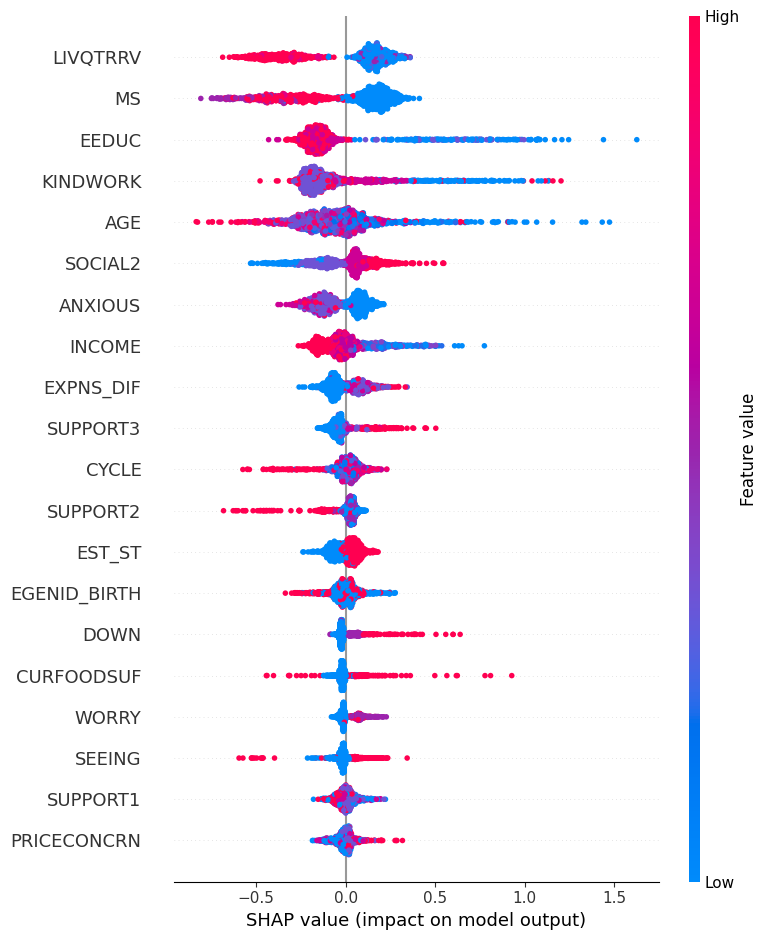

Generating SHAP Bar plot...


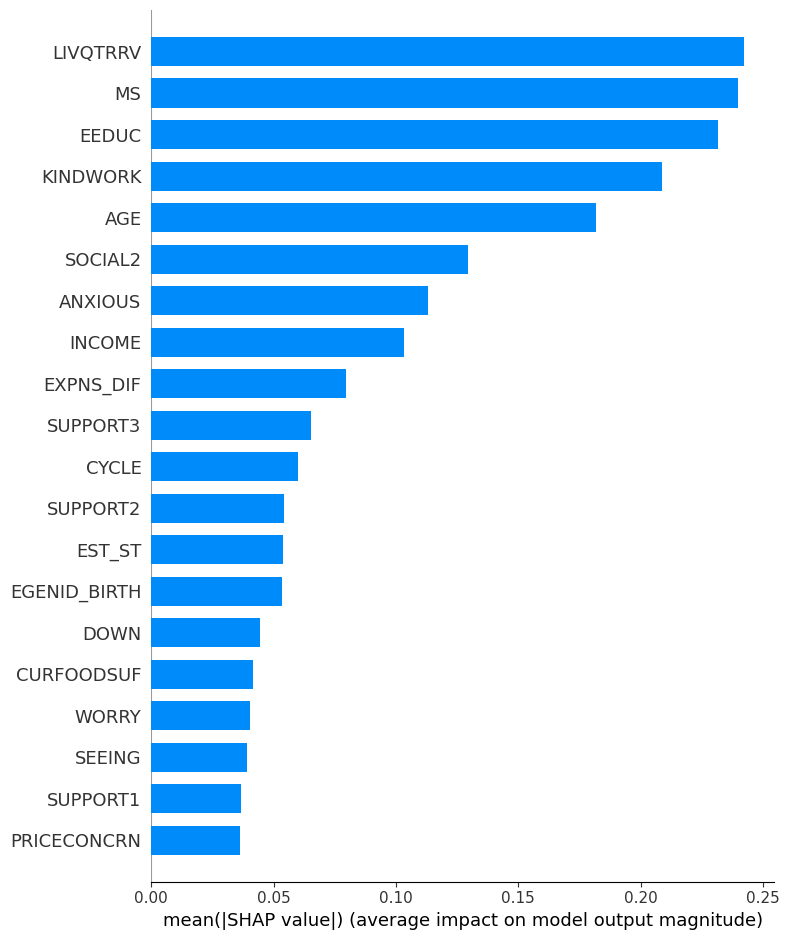

In [ ]:
print("\nCalculating and plotting SHAP values for XGBoost model...")

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test_final)

# --- SHAP Beeswarm (summary) Plot ---
print("Generating SHAP Beeswarm plot...")
shap.summary_plot(shap_values, X_test_final)

# --- SHAP Bar Plot of Mean Absolute SHAP Values ---
print("Generating SHAP Bar plot...")
shap.summary_plot(shap_values, X_test_final, plot_type="bar")

# (Optional) If you want to examine a single observation or more advanced plots:
# idx_to_explain = 0  # index in X_test_final
# shap.force_plot(
#     explainer.expected_value,
#     shap_values[idx_to_explain,:],
#     X_test_final.iloc[idx_to_explain,:],
#     matplotlib=True
# )

# CPS Binary Classification Model

In [30]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.feature_selection import RFECV, SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline
from joblib import parallel_backend
import xgboost as xgb
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [31]:
# Load and prepare data
filtered_df = pd.read_csv("filtered_df.csv")
filtered_df = filtered_df[(filtered_df['gestfips']==34) | (filtered_df['gestfips']==36)]

In [32]:
X = filtered_df[['hehousut','hetelhhd','hetelavl','hefaminc','hrnumhou','hrhtype','HUBUS','gereg','gediv','gestfips','gtcbsa','gtco','gtcbsast','gtmetsta','gtindvpc','gtcbsasz','gtcsa','perrp','prtage','pemaritl','pesex','peeduca','ptdtrace','prdthsp','PUCHINHH','prfamrel','prfamtyp','pehspnon','penatvty','pemntvty','pefntvty','prcitshp','prinuyer','PUWK','pemjot','pemjnum','pehruslt','pehractt','peio1cow','prdtind1','prdtocc1','pternwa','ptwk','prchld','prnmchld']]
y = filtered_df['pttlwk']

In [33]:
X

,hehousut,hetelhhd,hetelavl,hefaminc,hrnumhou,hrhtype,HUBUS,gereg,gediv,gestfips,...,pemjnum,pehruslt,pehractt,peio1cow,prdtind1,prdtocc1,pternwa,ptwk,prchld,prnmchld
651,1,1,-1,14,2,1,1,1,2,34,...,-1.0,40.0,48.0,4.0,25.0,21.0,-1.0,0,0.0,0.0
652,1,1,-1,14,2,1,1,1,2,34,...,-1.0,40.0,40.0,2.0,51.0,14.0,-1.0,0,0.0,0.0
653,1,1,-1,11,2,6,2,1,2,34,...,-1.0,40.0,40.0,4.0,14.0,22.0,-1.0,0,0.0,0.0
654,1,1,-1,11,2,6,2,1,2,34,...,-1.0,40.0,40.0,4.0,22.0,17.0,-1.0,0,0.0,0.0
655,1,2,2,12,2,4,2,1,2,34,...,-1.0,20.0,20.0,7.0,36.0,7.0,-1.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318282,1,1,2,10,2,4,2,1,2,36,...,-1.0,40.0,40.0,4.0,42.0,11.0,-1.0,0,0.0,0.0
318283,1,1,-1,15,1,6,2,1,2,36,...,-1.0,40.0,40.0,1.0,51.0,20.0,-1.0,0,0.0,0.0
318284,1,1,-1,14,2,1,1,1,2,36,...,-1.0,50.0,50.0,4.0,40.0,13.0,-1.0,0,0.0,0.0
318399,1,1,-1,16,3,4,2,1,2,34,...,-1.0,20.0,20.0,4.0,22.0,16.0,-1.0,0,0.0,0.0


In [34]:
# Convert labels from 1.0/2.0 to 0/1
y = (y == 2.0).astype(int)

In [35]:
y.value_counts()

,count
pttlwk,
1,13529
0,4290


In [36]:
# # Initialize label encoders dictionary
# encoders = {}

# # Label encode all feature columns
# for column in X.columns:
#     encoders[column] = LabelEncoder()
#     X[column] = encoders[column].fit_transform(X[column])

# # Label encode target variable
# target_encoder = LabelEncoder()
# y = target_encoder.fit_transform(y)

# print("Shape of X after encoding:", X.shape)
# print("Shape of y after encoding:", y.shape)
# print("\nUnique values in target variable:", np.unique(y))

In [37]:
# print("Performing initial feature selection...")
# selector = SelectKBest(mutual_info_classif, k=100)  # Keep top 50 features
# X_reduced = selector.fit_transform(X, y)
# selected_features = X.columns[selector.get_support(indices=True)]
# print("Top 50 features selected.")

In [38]:
#| label: vif
# Create a DataFrame with reduced features for VIF and further steps
# X = pd.DataFrame(X_reduced, columns=selected_features)

def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Calculate VIF for all features
print("Performing multicollinearity analysis...")
vif_data = calculate_vif(X)
print("VIF Results:")
print(vif_data)

# Drop features with high VIF (>10)
high_vif_features = vif_data[vif_data["VIF"] > 10]["Feature"].tolist()
print(f"Dropping features with high VIF: {high_vif_features}")
X = X.drop(columns=high_vif_features)

Performing multicollinearity analysis...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


VIF Results:
     Feature        VIF
0   hehousut   1.046027
1   hetelhhd   2.254292
2   hetelavl   2.282600
3   hefaminc   1.434420
4   hrnumhou   2.452866
5    hrhtype   4.732866
6      HUBUS   1.156651
7      gereg   0.000000
8      gediv   0.000000
9   gestfips   2.652757
10    gtcbsa   2.183617
11      gtco   2.202980
12  gtcbsast   4.391335
13  gtmetsta   2.231556
14  gtindvpc   2.651372
15  gtcbsasz   9.794757
16     gtcsa   5.458005
17     perrp   5.387685
18    prtage   1.678536
19  pemaritl   3.464919
20     pesex   1.148676
21   peeduca   1.524835
22  ptdtrace   1.271114
23   prdthsp   5.773714
24  PUCHINHH   1.015834
25  prfamrel   6.719113
26  prfamtyp   4.662360
27  pehspnon   5.659180
28  penatvty   7.903467
29  pemntvty   8.318010
30  pefntvty   7.946751
31  prcitshp  12.204819
32  prinuyer   8.446316
33      PUWK   1.015886
34    pemjot  83.410023
35   pemjnum  83.510317
36  pehruslt   2.022003
37  pehractt   2.050188
38  peio1cow   1.171097
39  prdtind1   1.193875
40 

In [39]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [40]:
# Recursive Feature Elimination
print("Performing Recursive Feature Elimination...")
with parallel_backend('threading'):
    rf_model = RandomForestClassifier(random_state=42)
    rfecv = RFECV(estimator=rf_model, step=1, cv=5, scoring='accuracy', n_jobs=-1)
    rfecv.fit(X_train, y_train)

# Get selected features from RFE
rfe_selected_features = rfecv.support_
X_train_final = X_train.iloc[:, rfe_selected_features]
X_test_final = X_test.iloc[:, rfe_selected_features]

Performing Recursive Feature Elimination...


In [41]:
# # Outlier Analysis
# print("Performing outlier analysis...")
# z_scores = np.abs((X_train_final - np.mean(X_train_final, axis=0)) / np.std(X_train_final, axis=0))
# threshold = 3
# non_outliers = (z_scores < threshold).all(axis=1)
# outlier_percentage = 100 * (1 - np.sum(non_outliers) / len(non_outliers))
# print(f"Percentage of outliers removed: {outlier_percentage:.2f}%")

# # Align indices before filtering
# X_train_final = X_train_final[non_outliers].reset_index(drop=True)
# # Use the index from X_train_final before reset to filter y_train
# y_train = y_train[X_train_final.index[non_outliers]].reset_index(drop=True)

In [42]:
X_train_final

,hefaminc,hrnumhou,hrhtype,HUBUS,gestfips,gtcbsa,gtco,gtcbsast,gtindvpc,gtcbsasz,...,pefntvty,prinuyer,pehruslt,pehractt,peio1cow,prdtind1,prdtocc1,pternwa,prchld,prnmchld
143322,9,2,6,2,36,15380,0,1,1,5,...,57.0,0.0,30.0,30.0,4.0,46.0,13.0,-1.0,0.0,0.0
318280,15,2,1,2,36,10580,0,1,0,4,...,117.0,0.0,40.0,40.0,4.0,19.0,22.0,-1.0,0.0,0.0
316593,16,9,1,2,36,35620,81,1,1,7,...,333.0,0.0,25.0,25.0,1.0,51.0,12.0,-1.0,0.0,0.0
78397,11,4,1,2,34,0,0,4,0,0,...,57.0,0.0,40.0,40.0,3.0,40.0,22.0,-1.0,0.0,0.0
92298,15,2,1,2,34,45940,21,4,0,3,...,57.0,0.0,40.0,1.0,4.0,19.0,17.0,-1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143188,16,4,1,2,34,35620,13,2,0,7,...,57.0,0.0,40.0,40.0,1.0,51.0,7.0,-1.0,5.0,2.0
164531,11,5,3,2,36,35620,5,1,1,7,...,328.0,24.0,25.0,25.0,3.0,51.0,12.0,-1.0,0.0,0.0
44316,13,1,6,2,36,0,0,3,0,0,...,57.0,0.0,40.0,40.0,4.0,42.0,21.0,72000.0,0.0,0.0
297427,12,3,1,2,34,35620,13,2,0,7,...,370.0,28.0,60.0,60.0,7.0,36.0,9.0,-1.0,3.0,1.0


In [43]:
# Convert to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train_final, label=y_train)
dtest = xgb.DMatrix(X_test_final, label=y_test)

# Define XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'seed': 42
}

# Cross-validation
print("Performing cross-validation...")
num_round = 100
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_round,
    nfold=5,
    metrics=['auc', 'error'],
    early_stopping_rounds=20,
    verbose_eval=True
)

Performing cross-validation...
[0]	train-auc:0.84550+0.00162	train-error:0.24076+0.00117	test-auc:0.83084+0.00405	test-error:0.24076+0.00468
[1]	train-auc:0.85108+0.00091	train-error:0.24076+0.00117	test-auc:0.83766+0.00555	test-error:0.24076+0.00468
[2]	train-auc:0.85450+0.00175	train-error:0.24076+0.00117	test-auc:0.84107+0.00493	test-error:0.24076+0.00468
[3]	train-auc:0.85600+0.00190	train-error:0.24076+0.00117	test-auc:0.84246+0.00456	test-error:0.24076+0.00468
[4]	train-auc:0.85822+0.00136	train-error:0.24076+0.00117	test-auc:0.84453+0.00454	test-error:0.24076+0.00468


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:11:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	train-auc:0.86179+0.00331	train-error:0.24046+0.00104	test-auc:0.84622+0.00409	test-error:0.24062+0.00477
[6]	train-auc:0.86704+0.00245	train-error:0.22038+0.01036	test-auc:0.85064+0.00415	test-error:0.22448+0.00933
[7]	train-auc:0.86990+0.00301	train-error:0.20051+0.00366	test-auc:0.85308+0.00421	test-error:0.20744+0.00496
[8]	train-auc:0.87272+0.00163	train-error:0.18886+0.00164	test-auc:0.85495+0.00438	test-error:0.19551+0.00420
[9]	train-auc:0.87495+0.00115	train-error:0.18346+0.00179	test-auc:0.85689+0.00411	test-error:0.19074+0.00270
[10]	train-auc:0.87717+0.00113	train-error:0.18143+0.00199	test-auc:0.85855+0.00410	test-error:0.18871+0.00339
[11]	train-auc:0.87898+0.00138	train-error:0.17866+0.00137	test-auc:0.86038+0.00398	test-error:0.18702+0.00132
[12]	train-auc:0.88076+0.00112	train-error:0.17608+0.00184	test-auc:0.86169+0.00396	test-error:0.18471+0.00357
[13]	train-auc:0.88210+0.00097	train-error:0.17420+0.00198	test-auc:0.86243+0.00393	test-error:0.18302+0.00244
[14]	t


Cross-validation results:
Best AUC: 0.8887 (+/- 0.0034)
Best Error: 0.1568 (+/- 0.0013)

Training final model...

Comprehensive Model Performance Metrics:


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:11:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)



Accuracy: 0.8443
Precision (Positive Predictive Value): 0.8764
Recall (Sensitivity/True Positive Rate): 0.9254
Specificity (True Negative Rate): 0.5886
False Positive Rate: 0.4114
False Negative Rate: 0.0746
F1 Score: 0.9002
Prevalence: 0.7593
Negative Predictive Value: 0.7143
Positive Likelihood Ratio: 2.2492
Negative Likelihood Ratio: 0.1268

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.59      0.65       858
           1       0.88      0.93      0.90      2706

    accuracy                           0.84      3564
   macro avg       0.80      0.76      0.77      3564
weighted avg       0.84      0.84      0.84      3564


Confusion Matrix:
[[ 505  353]
 [ 202 2504]]

ROC AUC Score: 0.8916

Top 10 Most Important Features:
     Feature  Importance
26  prdtocc1       234.0
25  prdtind1       223.0
12    prtage       176.0
6       gtco       134.0
15   peeduca       127.0
23  pehractt       126.0
0   hefaminc       111.0


<ipython-input-44-4057e82e3a32>:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')


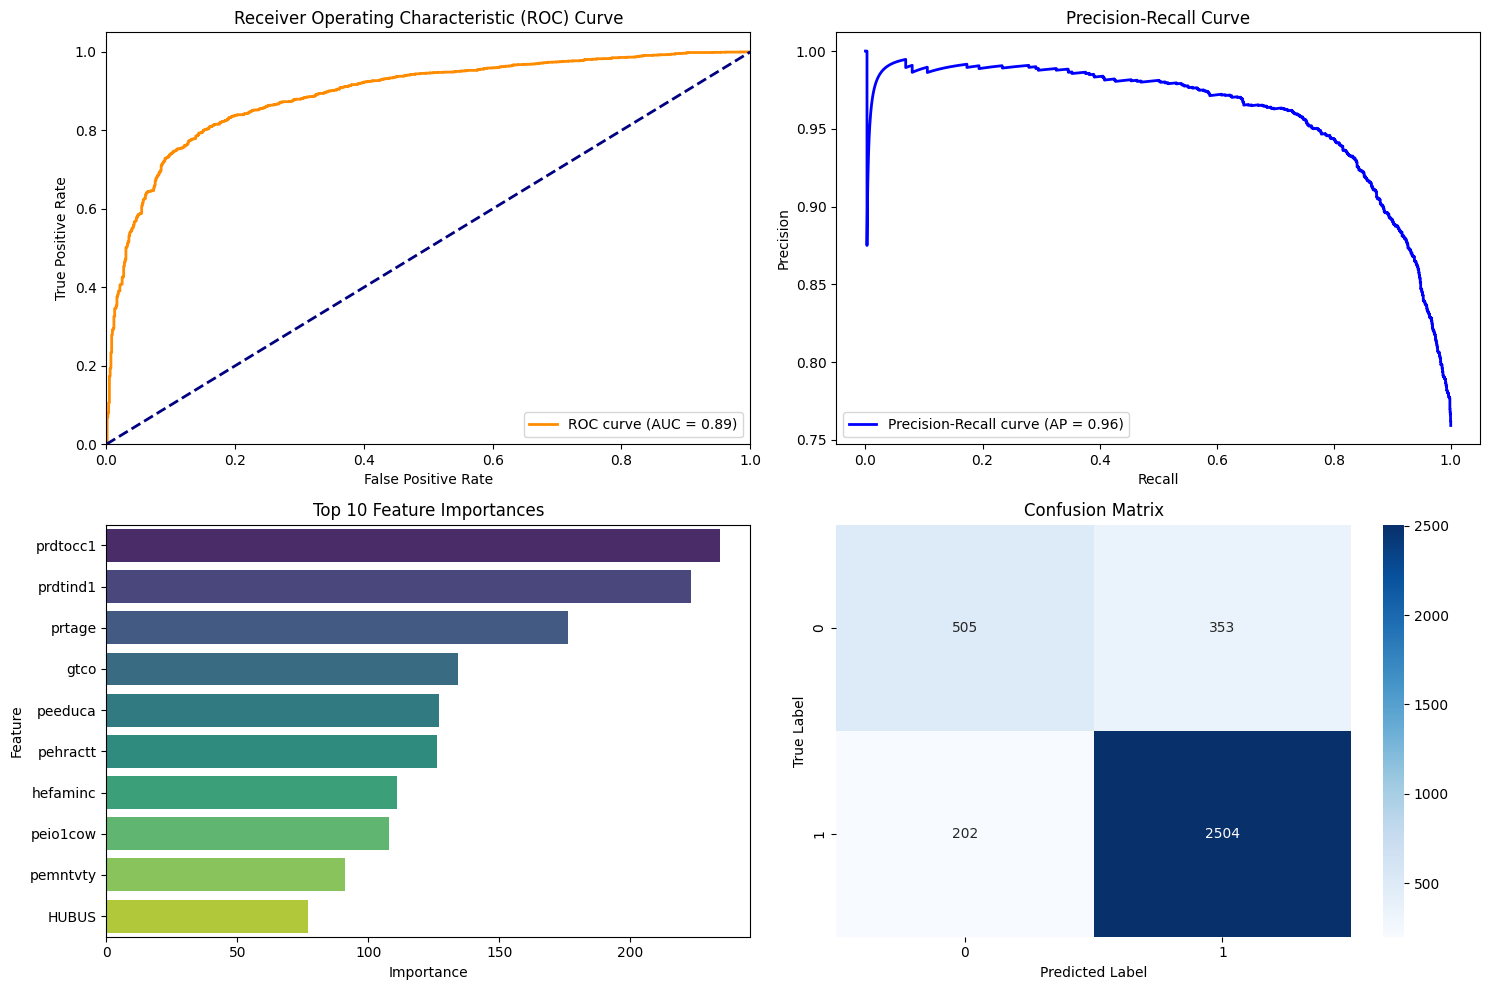

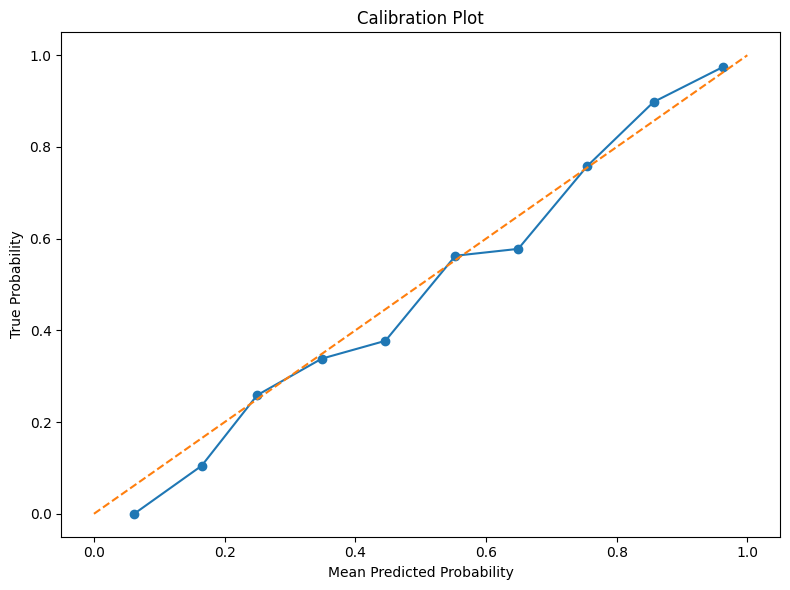

In [44]:
#| label: results
import numpy as np
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score

# Print CV results
print("\nCross-validation results:")
print(f"Best AUC: {cv_results['test-auc-mean'].max():.4f} (+/- {cv_results['test-auc-std'].min():.4f})")
print(f"Best Error: {cv_results['test-error-mean'].min():.4f} (+/- {cv_results['test-error-std'].min():.4f})")

# Train final model
print("\nTraining final model...")
final_model = xgb.train(params, dtrain, num_round)

# Make predictions
y_pred = final_model.predict(dtest)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate additional metrics
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
total = tn + fp + fn + tp

# Basic Metrics
accuracy = (tp + tn) / total
precision = tp / (tp + fp)
recall = tp / (tp + fn)  # Also known as True Positive Rate
specificity = tn / (tn + fp)  # True Negative Rate
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (fn + tp)
f1 = 2 * (precision * recall) / (precision + recall)

# Additional Metrics
prevalence = (tp + fn) / total
positive_predictive_value = tp / (tp + fp)  # Same as precision
negative_predictive_value = tn / (tn + fn)
positive_likelihood_ratio = recall / false_positive_rate
negative_likelihood_ratio = false_negative_rate / specificity

print("\nComprehensive Model Performance Metrics:")
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision (Positive Predictive Value): {precision:.4f}")
print(f"Recall (Sensitivity/True Positive Rate): {recall:.4f}")
print(f"Specificity (True Negative Rate): {specificity:.4f}")
print(f"False Positive Rate: {false_positive_rate:.4f}")
print(f"False Negative Rate: {false_negative_rate:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Prevalence: {prevalence:.4f}")
print(f"Negative Predictive Value: {negative_predictive_value:.4f}")
print(f"Positive Likelihood Ratio: {positive_likelihood_ratio:.4f}")
print(f"Negative Likelihood Ratio: {negative_likelihood_ratio:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print(conf_matrix)

print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred):.4f}")

# Calculate ROC and PR curves
fpr, tpr, _ = roc_curve(y_test, y_pred)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)

# Feature importance analysis
importance = final_model.get_score(importance_type='weight')
importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df)

# Plotting
plt.figure(figsize=(15, 10))

# Plot 1: ROC Curve
plt.subplot(2, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_pred):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot 2: Precision-Recall Curve
plt.subplot(2, 2, 2)
plt.plot(recall_curve, precision_curve, color='blue', lw=2,
         label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

# Plot 3: Feature Importance
plt.subplot(2, 2, 3)
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Plot 4: Confusion Matrix
plt.subplot(2, 2, 4)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Optional: Print calibration metrics
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, y_pred, n_bins=10)

# Plot calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Plot')
plt.tight_layout()
plt.show()

In [45]:
#| label: probit
import statsmodels.api as sm
import shap
print("\nFitting Probit model for effect sizes and p-values...")

# We add a constant for statsmodels
X_train_final.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_train_probit = sm.add_constant(X_train_final)
probit_model = sm.Probit(y_train, X_train_probit)
probit_results = probit_model.fit()
print("\nProbit Model Summary:")
print(probit_results.summary())

# Optionally compute marginal effects
print("\nMarginal Effects (Probit):")
marginal_effects = probit_results.get_margeff()
print(marginal_effects.summary())


Fitting Probit model for effect sizes and p-values...
Optimization terminated successfully.
         Current function value: 0.427806
         Iterations 6

Probit Model Summary:
                          Probit Regression Results                           
Dep. Variable:                 pttlwk   No. Observations:                14255
Model:                         Probit   Df Residuals:                    14224
Method:                           MLE   Df Model:                           30
Date:                Sat, 01 Feb 2025   Pseudo R-squ.:                  0.2249
Time:                        21:12:39   Log-Likelihood:                -6098.4
converged:                       True   LL-Null:                       -7868.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2208      0.9


Calculating and plotting SHAP values for XGBoost model...
Generating SHAP Beeswarm plot...


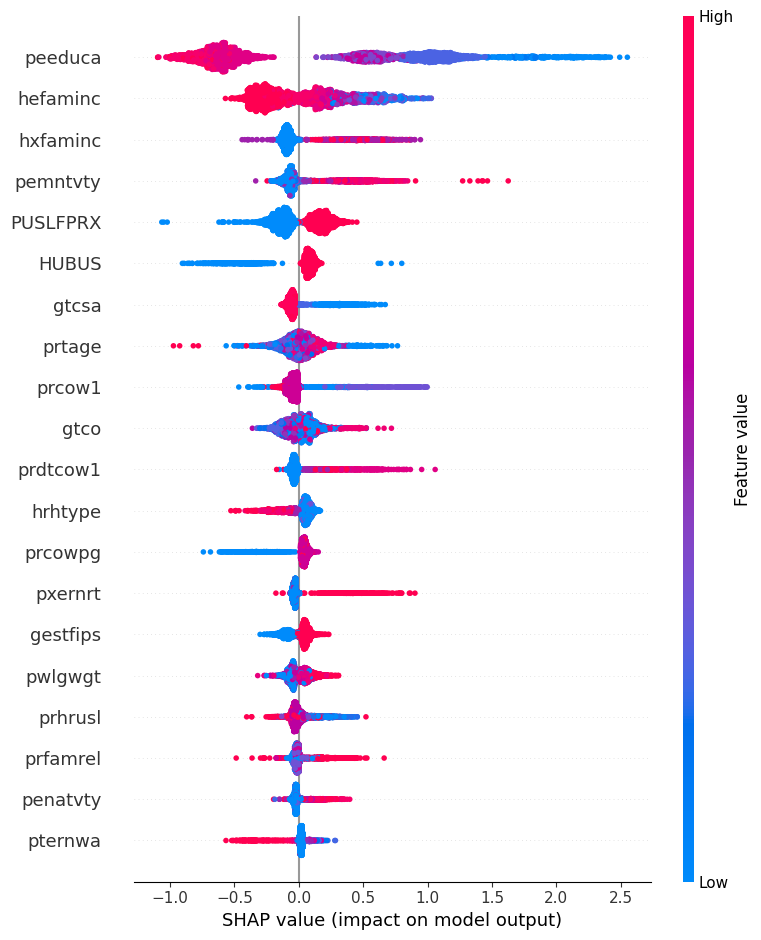

Generating SHAP Bar plot...


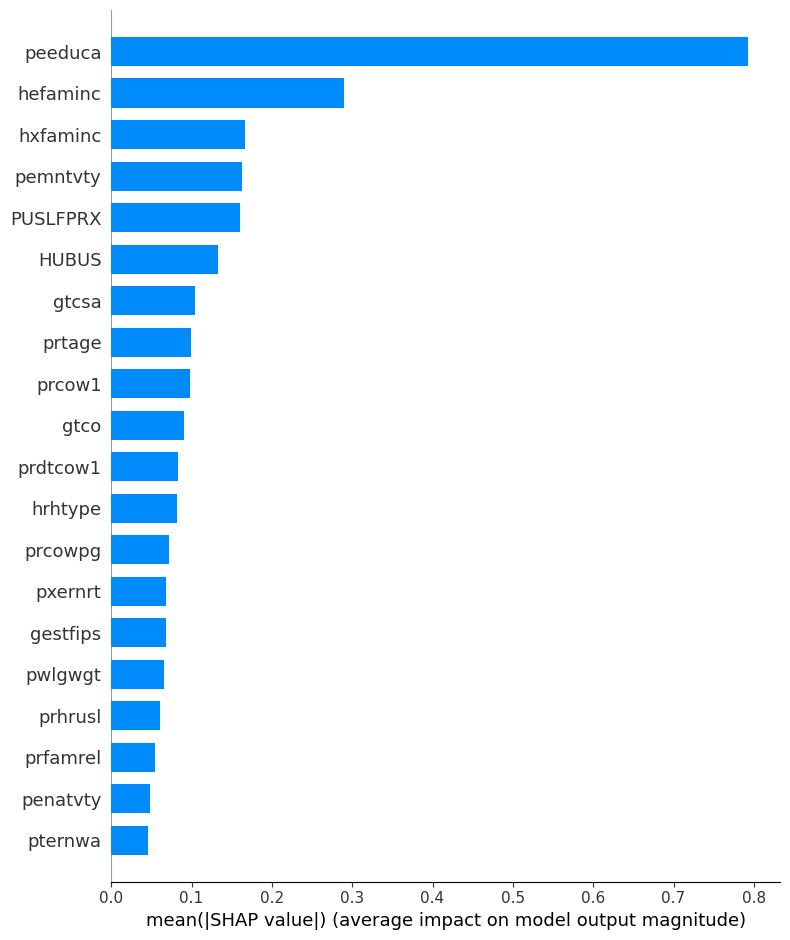

In [ ]:
#| label: shap
print("\nCalculating and plotting SHAP values for XGBoost model...")

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test_final)

# --- SHAP Beeswarm (summary) Plot ---
print("Generating SHAP Beeswarm plot...")
shap.summary_plot(shap_values, X_test_final)

# --- SHAP Bar Plot of Mean Absolute SHAP Values ---
print("Generating SHAP Bar plot...")
shap.summary_plot(shap_values, X_test_final, plot_type="bar")

# (Optional) If you want to examine a single observation or more advanced plots:
# idx_to_explain = 0  # index in X_test_final
# shap.force_plot(
#     explainer.expected_value,
#     shap_values[idx_to_explain,:],
#     X_test_final.iloc[idx_to_explain,:],
#     matplotlib=True
# )

In [ ]:
# pip install bayesian-optimization

Scaling features...
Performing feature selection...


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  7   8   9  16  17  24  26  32  42  53  66  69  71  72  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
 107 109 115 160 173 174 175 176 177 178 179 180 181 182 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 211 212 213 214 215 218 219 220
 221 222 223 224 225 238 239 240 241 242 243 244 245 246 247 248 249 250
 251 255 256 257 258 259 260 261 263 264 267 270 271 272 274 291] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Performing multicollinearity analysis...


/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



VIF Results:
      Feature         VIF
0    OCCURNUM         inf
1       HUBUS    3.104158
2     HUBUSL1    3.040994
3    hehousut    1.053932
4    hrnumhou    1.613758
5    hefaminc    1.366005
6    hxfaminc    1.041178
7    PULINENO         inf
8    PUIO1MFG    1.200420
9    PUSLFPRX    1.730368
10      perrp    3.068334
11   pemaritl  450.277952
12    pxrace1    1.239154
13   pehspnon    3.504174
14    peeduca    1.865216
15   pespouse   10.326498
16   pemntvty    5.751234
17   pefntvty    5.795244
18   pedipged    1.620007
19      pecyc    1.261176
20     pepar1    6.813180
21     pepar2    7.247503
22  pepar1typ    8.514617
23  pepar2typ    8.421113
24   prmarsta  547.232596
25    prdthsp    3.022894
26   prfamrel    2.549348
27     prtage    1.580120
28    pemjnum    1.034042
29   peio1icd   11.798984
30   prmjind1   31.276246
31   prmjocc1   92.513207
32   prdtind1   41.036307
33   prdtocc1   34.092564
34    prcowpg    1.424787
35   prmjocgr   48.168168
36   peernwkp    1.83448

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 1         | 0.7732    | 0.6873    | 0.2857    | 8.124     | 139.8     | 0.578     |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 2         | 0.7872    | 0.578     | 0.02684   | 9.063     | 140.2     | 0.854     |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 3         | 0.7812    | 0.5103    | 0.2913    | 8.827     | 81.85     | 0.5909    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 4         | 0.7909    | 0.5917    | 0.09823   | 6.673     | 114.8     | 0.6456    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 5         | 0.7862    | 0.8059    | 0.05045   | 5.045     | 105.0     | 0.728     |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 6         | 0.7849    | 0.68      | 0.2875    | 6.503     | 114.9     | 0.7288    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 7         | 0.7828    | 0.7325    | 0.2368    | 6.817     | 114.4     | 0.7645    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 8         | 0.7914    | 0.8502    | 0.08643   | 6.483     | 114.6     | 0.742     |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 9         | 0.7805    | 0.6778    | 0.02618   | 6.569     | 114.7     | 0.8147    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 10        | 0.786     | 0.9038    | 0.06098   | 5.217     | 90.33     | 0.8629    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 11        | 0.7864    | 0.7456    | 0.08416   | 8.146     | 139.4     | 0.899     |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 12        | 0.785     | 0.5377    | 0.2455    | 6.267     | 95.87     | 0.6494    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 13        | 0.781     | 0.5413    | 0.2721    | 7.156     | 162.5     | 0.874     |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 14        | 0.7825    | 0.8641    | 0.2036    | 9.962     | 111.0     | 0.7694    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:07:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 15        | 0.7889    | 0.5668    | 0.2238    | 5.109     | 78.43     | 0.6134    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:07:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 16        | 0.7899    | 0.6357    | 0.199     | 3.435     | 162.1     | 0.9796    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:07:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 17        | 0.7862    | 0.5819    | 0.03932   | 4.665     | 186.8     | 0.8976    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:07:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 18        | 0.7827    | 0.8887    | 0.1137    | 8.863     | 190.2     | 0.5815    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:07:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 19        | 0.7818    | 0.7528    | 0.1584    | 8.54      | 99.56     | 0.9612    |


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:07:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 20        | 0.7884    | 0.9319    | 0.1759    | 5.914     | 77.49     | 0.6407    |

Best parameters found:
{'colsample_bytree': 0.8502042604408235, 'learning_rate': 0.08643263337802379, 'max_depth': 6.482992630463139, 'n_estimators': 114.61319594670005, 'subsample': 0.7420110182828307}

Training final model with best parameters...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:07:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)



Model Performance Metrics:

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.55      0.51      1364
           1       0.86      0.82      0.84      4618

    accuracy                           0.76      5982
   macro avg       0.67      0.69      0.68      5982
weighted avg       0.77      0.76      0.77      5982



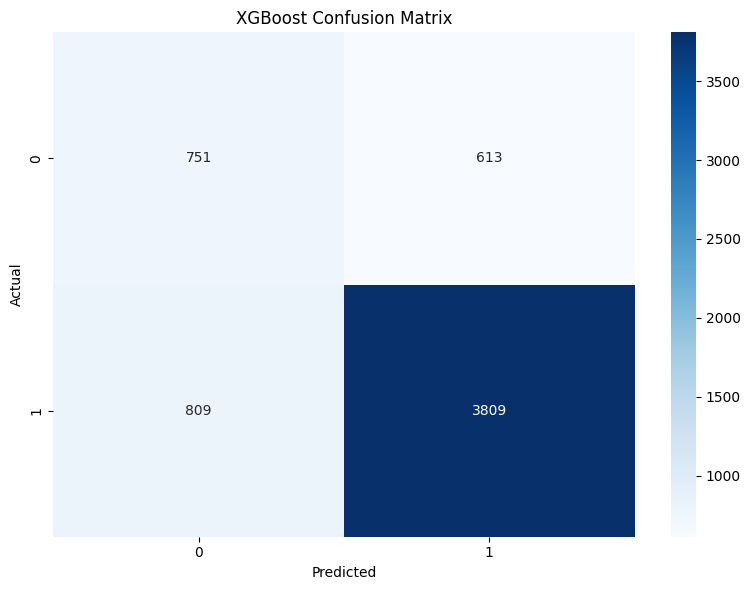

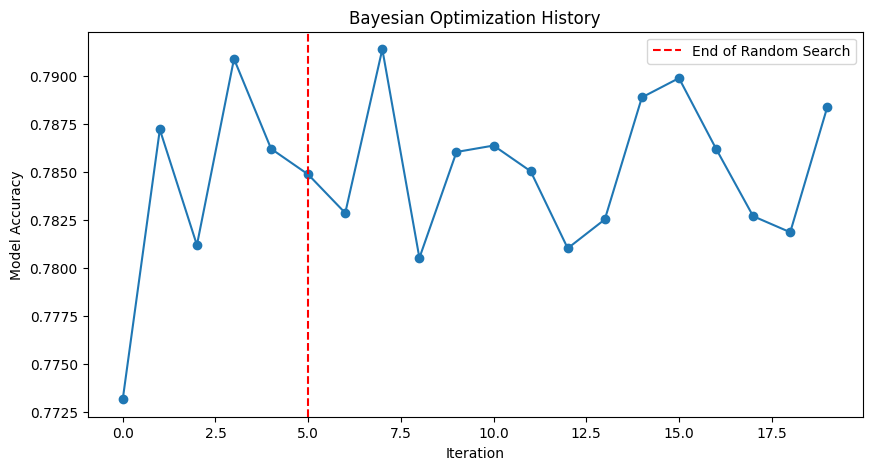

<ipython-input-17-4ab47d6bebcb>:183: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')


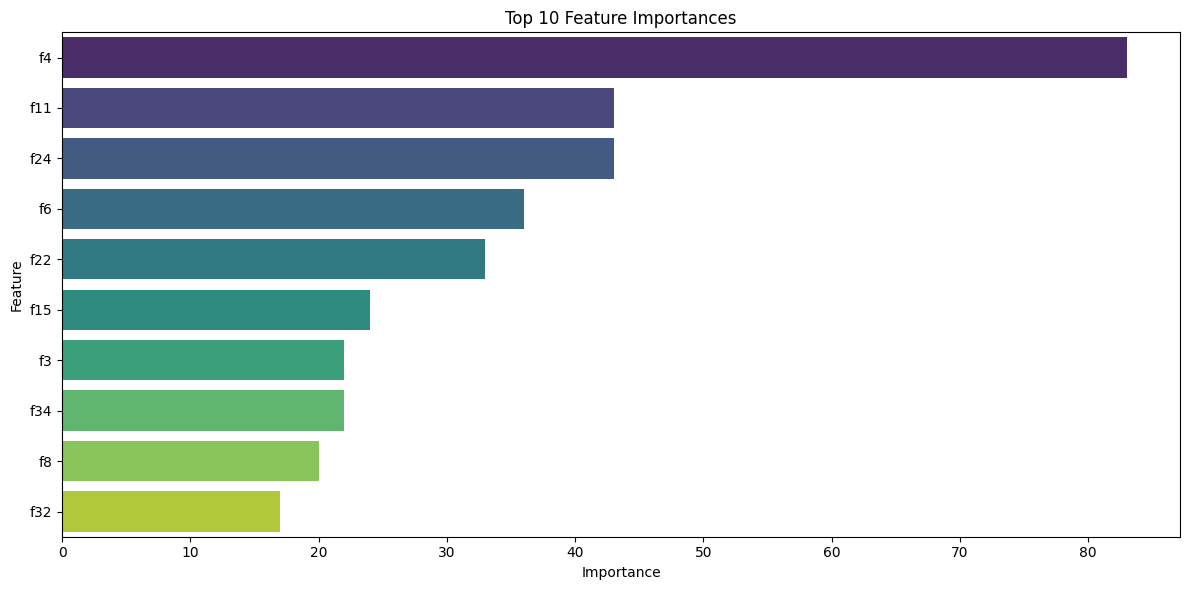

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.feature_selection import SelectKBest, f_classif
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# import xgboost as xgb
# import matplotlib.pyplot as plt
# import seaborn as sns
# from imblearn.over_sampling import SMOTE
# from bayes_opt import BayesianOptimization

# # Load and prepare data
# filtered_df = pd.read_csv("filtered_df.csv")
# X = filtered_df.drop(['pttlwk', 'pxtlwkhr', 'pttlwkhr', 'pxtlwk'], axis=1)
# y = filtered_df['pttlwk']

# # Convert labels from 1.0/2.0 to 0/1
# y = (y == 2.0).astype(int)

# # Split the data first
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # Reset indices to ensure alignment
# X_train = X_train.reset_index(drop=True)
# X_test = X_test.reset_index(drop=True)
# y_train = y_train.reset_index(drop=True)
# y_test = y_test.reset_index(drop=True)

# # Scale the features
# print("Scaling features...")
# scaler = StandardScaler()
# X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
# X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# # Feature selection
# print("Performing feature selection...")
# selector = SelectKBest(f_classif, k=50)
# X_train_reduced = selector.fit_transform(X_train_scaled, y_train)
# X_test_reduced = selector.transform(X_test_scaled)

# # Get selected feature names
# selected_features = X_train.columns[selector.get_support()].tolist()
# X_train_reduced = pd.DataFrame(X_train_reduced, columns=selected_features)
# X_test_reduced = pd.DataFrame(X_test_reduced, columns=selected_features)

# # Calculate VIF
# print("Performing multicollinearity analysis...")
# vif_data = pd.DataFrame()
# vif_data["Feature"] = selected_features
# vif_data["VIF"] = [variance_inflation_factor(X_train_reduced.values, i)
#                    for i in range(X_train_reduced.shape[1])]
# print("\nVIF Results:")
# print(vif_data)

# # Drop high VIF features
# high_vif_features = vif_data[vif_data["VIF"] > 10]["Feature"].tolist()
# print(f"\nDropping features with high VIF: {high_vif_features}")
# X_train_vif = X_train_reduced.drop(columns=high_vif_features)
# X_test_vif = X_test_reduced.drop(columns=high_vif_features)

# # Outlier removal
# print("\nPerforming outlier analysis...")
# z_scores = np.abs((X_train_vif - X_train_vif.mean()) / X_train_vif.std())
# threshold = 3
# non_outliers = (z_scores < threshold).all(axis=1)

# # Make sure indices align before filtering
# X_train_clean = X_train_vif[non_outliers].reset_index(drop=True)
# y_train_clean = pd.Series(y_train.values[non_outliers]).reset_index(drop=True)

# # Apply SMOTE for class imbalance
# print("\nApplying SMOTE for class balancing...")
# smote = SMOTE(random_state=42)
# X_train_balanced, y_train_balanced = smote.fit_resample(X_train_clean, y_train_clean)

# # Convert to numpy arrays for XGBoost
# X_train_balanced = np.array(X_train_balanced)
# y_train_balanced = np.array(y_train_balanced)
# X_test_vif_array = np.array(X_test_vif)

# # Function for Bayesian Optimization
# def xgb_evaluate(max_depth, learning_rate, n_estimators, subsample, colsample_bytree):
#     params = {
#         'max_depth': int(max_depth),
#         'learning_rate': learning_rate,
#         'n_estimators': int(n_estimators),
#         'subsample': subsample,
#         'colsample_bytree': colsample_bytree,
#         'objective': 'binary:logistic',
#         'eval_metric': 'logloss',
#         'seed': 42
#     }

#     # Convert to DMatrix format
#     dtrain = xgb.DMatrix(X_train_balanced, label=y_train_balanced)
#     dtest = xgb.DMatrix(X_test_vif_array)

#     # Train model
#     model = xgb.train(params, dtrain, num_boost_round=int(n_estimators))

#     # Make predictions
#     y_pred = (model.predict(dtest) > 0.5).astype(int)

#     return accuracy_score(y_test, y_pred)

# # Initialize Bayesian Optimization
# print("\nStarting Bayesian Optimization...")
# optimizer = BayesianOptimization(
#     f=xgb_evaluate,
#     pbounds={
#         'max_depth': (3, 10),
#         'learning_rate': (0.01, 0.3),
#         'n_estimators': (50, 200),
#         'subsample': (0.5, 1.0),
#         'colsample_bytree': (0.5, 1.0)
#     },
#     random_state=42
# )

# # Run optimization
# optimizer.maximize(
#     init_points=5,
#     n_iter=15
# )

# # Get best parameters
# best_params = optimizer.max['params']
# print("\nBest parameters found:")
# print(best_params)

# # Train final model with best parameters
# print("\nTraining final model with best parameters...")
# final_params = {
#     'max_depth': int(best_params['max_depth']),
#     'learning_rate': best_params['learning_rate'],
#     'n_estimators': int(best_params['n_estimators']),
#     'subsample': best_params['subsample'],
#     'colsample_bytree': best_params['colsample_bytree'],
#     'objective': 'binary:logistic',
#     'eval_metric': 'logloss'
# }

# # Create final DMatrix objects
# dtrain = xgb.DMatrix(X_train_balanced, label=y_train_balanced)
# dtest = xgb.DMatrix(X_test_vif_array)

# # Train final model
# final_model = xgb.train(final_params, dtrain)
# y_pred = (final_model.predict(dtest) > 0.5).astype(int)

# # Print results
# print("\nModel Performance Metrics:")
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))

# # Plot confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
# plt.title('XGBoost Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.tight_layout()
# plt.show()

# # Plot optimization history
# plt.figure(figsize=(10, 5))
# plt.plot(range(len(optimizer.space.target)), optimizer.space.target, '-o')
# plt.xlabel('Iteration')
# plt.ylabel('Model Accuracy')
# plt.title('Bayesian Optimization History')
# plt.axvline(x=5, color='r', linestyle='--', label='End of Random Search')
# plt.legend()
# plt.show()

# # Feature importance
# importance = final_model.get_score(importance_type='weight')
# importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])
# importance_df = importance_df.sort_values(by='Importance', ascending=False)

# plt.figure(figsize=(12, 6))
# sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')
# plt.title('Top 10 Feature Importances')
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.tight_layout()
# plt.show()

# PUMS Classification model

In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.feature_selection import RFECV, SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline
from joblib import parallel_backend
import xgboost as xgb
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("psam_p34.csv")
df2 = pd.read_csv("psam_p36.csv")

In [ ]:
# Concatenate dataframes
merged_df = pd.concat([df, df2], axis=0)

# Drop weight columns
pwgtp_cols = [col for col in merged_df.columns if 'PWGTP' in col]
filtered_df = merged_df.drop(columns=pwgtp_cols)

# Transform JWTRNS (0 for values 1-10, 1 for value 11)
filtered_df['JWTRNS'] = (filtered_df['JWTRNS'] == 11).astype(int)

print(f"Original shapes: df {df.shape}, df2 {df2.shape}")
print(f"Combined shape: {merged_df.shape}")
print(f"Final shape: {filtered_df.shape}")
print("\nJWTRNS distribution:")
print(filtered_df['JWTRNS'].value_counts())

Original shapes: df (94314, 287), df2 (206408, 287)
Combined shape: (300722, 287)
Final shape: (300722, 206)

JWTRNS distribution:
JWTRNS
0    281466
1     19256
Name: count, dtype: int64


In [ ]:
filtered_df

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,STATE,ADJINC,AGEP,CIT,...,FSEMP,FSEXP,FSSIP,FSSP,FWAGP,FWKHP,FWKLP,FWKWNP,FWRKP,FYOEP
0,P,2023GQ0000001,2,1,2501,1,34,1019518,94,1,...,0,0,0,1,0,0,0,0,0,0
1,P,2023GQ0000002,2,1,603,1,34,1019518,18,1,...,0,0,0,0,0,0,0,0,0,0
2,P,2023GQ0000021,2,1,2103,1,34,1019518,78,1,...,0,0,0,0,0,0,0,0,0,0
3,P,2023GQ0000058,2,1,307,1,34,1019518,79,1,...,0,0,0,0,0,0,0,0,0,0
4,P,2023GQ0000158,2,1,1201,1,34,1019518,63,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206403,P,2023HU1459885,2,4,4503,1,36,1019518,61,5,...,0,0,0,0,0,0,0,0,0,0
206404,P,2023HU1459885,2,5,4503,1,36,1019518,60,5,...,0,0,0,0,0,0,0,0,0,0
206405,P,2023HU1459895,2,1,2201,1,36,1019518,28,1,...,0,0,1,1,1,1,0,0,0,0
206406,P,2023HU1459895,2,2,2201,1,36,1019518,4,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
def clean_dataframe(df, column_threshold=0.1):
    """
    Removes columns with more than `column_threshold`% NaN values,
    then removes remaining rows with NaNs.

    Parameters:
    df (pd.DataFrame): Input DataFrame
    column_threshold (float): Threshold for dropping columns (default 40%)

    Returns:
    pd.DataFrame: Cleaned DataFrame
    """
    # Calculate percentage of NaNs per column
    nan_percentage = df.isna().mean()

    # Drop columns exceeding the threshold
    cols_to_drop = nan_percentage[nan_percentage > column_threshold].index
    df_cleaned = df.drop(columns=cols_to_drop)

    # Drop remaining rows with NaNs
    df_cleaned = df_cleaned.dropna()

    return df_cleaned

filtered_df_new = clean_dataframe(filtered_df, column_threshold=0.1)  # Set 40% threshold
print(f"Shape before: {filtered_df_new.shape}, Shape after: {filtered_df.shape}")

Shape before: (269827, 131), Shape after: (300722, 206)


In [ ]:
filtered_df_new

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,STATE,ADJINC,AGEP,CIT,DDRS,DEAR,DEYE,DPHY,DREM,HIMRKS,HINS1,HINS2,HINS3,HINS4,HINS5,HINS6,HINS7,JWTRNS,LANX,MAR,MIG,RELSHIPP,SCH,SCHL,SEX,ANC,ANC1P,ANC2P,DIS,HICOV,HISP,NATIVITY,OC,POBP,POVPIP,PRIVCOV,PUBCOV,QTRBIR,RAC1P,RAC2P,RAC3P,RACAIAN,RACASN,RACBLK,RACNH,RACNUM,RACPI,RACSOR,RACWHT,RC,WAOB,FAGEP,FANCP,FCITP,FCITWP,FCOWP,FDDRSP,FDEARP,FDEYEP,FDISP,FDOUTP,FDPHYP,FDRATP,FDRATXP,FDREMP,FENGP,FESRP,FFERP,FFODP,FGCLP,FGCMP,FGCRP,FHICOVP,FHIMRKSP,FHINS1P,FHINS2P,FHINS3P,FHINS4P,FHINS5P,FHINS6P,FHINS7P,FHISP,FINDP,FINTP,FJWDP,FJWMNP,FJWRIP,FJWTRNSP,FLANP,FLANXP,FMARP,FMARHDP,FMARHMP,FMARHTP,FMARHWP,FMARHYP,FMIGP,FMIGSP,FMILPP,FMILSP,FOCCP,FOIP,FPAP,FPERNP,FPINCP,FPOBP,FPOWSP,FPRIVCOVP,FPUBCOVP,FRACP,FRELSHIPP,FRETP,FSCHGP,FSCHLP,FSCHP,FSEMP,FSEXP,FSSIP,FSSP,FWAGP,FWKHP,FWKLP,FWKWNP,FWRKP,FYOEP
3350,P,2023HU0000023,2,1,1501,1,34,1019518,61,1,2.0,2,2,2.0,2.0,0,1,2,2,2,2,2,2,1,2.0,1,1.0,20,1.0,22.0,1,2,51,148,2,1,1,1,0.0,34,501.0,1,2,1,1,1000,1,0,0,0,0,1,0,0,1,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3351,P,2023HU0000023,2,2,1501,1,34,1019518,57,1,2.0,2,2,2.0,2.0,0,1,2,2,2,2,2,2,0,2.0,1,1.0,21,1.0,21.0,2,2,51,50,2,1,1,1,0.0,34,501.0,1,2,3,1,1000,1,0,0,0,0,1,0,0,1,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0
3352,P,2023HU0000023,2,3,1501,1,34,1019518,25,1,2.0,2,2,2.0,2.0,0,1,2,2,2,2,2,2,0,2.0,5,1.0,25,1.0,21.0,1,2,51,50,2,1,1,1,0.0,34,501.0,1,2,3,1,1000,1,0,0,0,0,1,0,0,1,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0
3353,P,2023HU0000023,2,4,1501,1,34,1019518,22,1,2.0,2,2,2.0,2.0,0,1,2,2,2,2,2,2,0,1.0,5,3.0,25,1.0,21.0,2,2,51,50,2,1,1,1,0.0,34,501.0,1,2,2,1,1000,1,0,0,0,0,1,0,0,1,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3354,P,2023HU0000229,2,1,602,1,34,1019518,36,5,2.0,2,2,2.0,2.0,0,1,2,2,2,2,2,2,0,1.0,5,1.0,20,1.0,22.0,1,1,785,999,2,1,1,2,0.0,247,501.0,1,2,3,6,4014,9,0,1,0,0,1,0,0,0,0.0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206401,P,2023HU1459885,2,2,4503,1,36,1019518,37,1,2.0,2,2,2.0,2.0,0,2,2,2,1,2,2,2,0,1.0,1,3.0,21,1.0,15.0,2,1,706,999,2,1,1,1,0.0,36,269.0,2,1,1,6,4000,5,0,1,0,0,1,0,0,0,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
206403,P,2023HU1459885,2,4,4503,1,36,1019518,61,5,2.0,2,2,2.0,2.0,0,2,2,2,1,2,2,2,0,1.0,1,3.0,29,1.0,1.0,1,1,706,999,2,1,1,2,0.0,207,269.0,2,1,3,6,4000,5,0,1,0,0,1,0,0,0,0.0,4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
206404,P,2023HU1459885,2,5,4503,1,36,1019518,60,5,2.0,2,2,2.0,2.0,0,2,2,2,1,2,2,2,0,2.0,1,3.0,29,1.0,1.0,2,1,706,999,2,1,1,2,0.0,207,269.0,2,1,2,6,4000,5,0,1,0,0,1,0,0,0,0.0,4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
206405,P,2023HU1459895,2,1,2201,1,36,1019518,28,1,2.0

In [ ]:
X = filtered_df_new.drop(['RT','SERIALNO','JWTRNS'], axis=1)
y = filtered_df_new['JWTRNS']

In [ ]:
X

,DIVISION,SPORDER,PUMA,REGION,STATE,ADJINC,AGEP,CIT,DDRS,DEAR,DEYE,DPHY,DREM,HIMRKS,HINS1,HINS2,HINS3,HINS4,HINS5,HINS6,HINS7,LANX,MAR,MIG,RELSHIPP,SCH,SCHL,SEX,ANC,ANC1P,ANC2P,DIS,HICOV,HISP,NATIVITY,OC,POBP,POVPIP,PRIVCOV,PUBCOV,QTRBIR,RAC1P,RAC2P,RAC3P,RACAIAN,RACASN,RACBLK,RACNH,RACNUM,RACPI,RACSOR,RACWHT,RC,WAOB,FAGEP,FANCP,FCITP,FCITWP,FCOWP,FDDRSP,FDEARP,FDEYEP,FDISP,FDOUTP,FDPHYP,FDRATP,FDRATXP,FDREMP,FENGP,FESRP,FFERP,FFODP,FGCLP,FGCMP,FGCRP,FHICOVP,FHIMRKSP,FHINS1P,FHINS2P,FHINS3P,FHINS4P,FHINS5P,FHINS6P,FHINS7P,FHISP,FINDP,FINTP,FJWDP,FJWMNP,FJWRIP,FJWTRNSP,FLANP,FLANXP,FMARP,FMARHDP,FMARHMP,FMARHTP,FMARHWP,FMARHYP,FMIGP,FMIGSP,FMILPP,FMILSP,FOCCP,FOIP,FPAP,FPERNP,FPINCP,FPOBP,FPOWSP,FPRIVCOVP,FPUBCOVP,FRACP,FRELSHIPP,FRETP,FSCHGP,FSCHLP,FSCHP,FSEMP,FSEXP,FSSIP,FSSP,FWAGP,FWKHP,FWKLP,FWKWNP,FWRKP,FYOEP
3350,2,1,1501,1,34,1019518,61,1,2.0,2,2,2.0,2.0,0,1,2,2,2,2,2,2,2.0,1,1.0,20,1.0,22.0,1,2,51,148,2,1,1,1,0.0,34,501.0,1,2,1,1,1000,1,0,0,0,0,1,0,0,1,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3351,2,2,1501,1,34,1019518,57,1,2.0,2,2,2.0,2.0,0,1,2,2,2,2,2,2,2.0,1,1.0,21,1.0,21.0,2,2,51,50,2,1,1,1,0.0,34,501.0,1,2,3,1,1000,1,0,0,0,0,1,0,0,1,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0
3352,2,3,1501,1,34,1019518,25,1,2.0,2,2,2.0,2.0,0,1,2,2,2,2,2,2,2.0,5,1.0,25,1.0,21.0,1,2,51,50,2,1,1,1,0.0,34,501.0,1,2,3,1,1000,1,0,0,0,0,1,0,0,1,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0
3353,2,4,1501,1,34,1019518,22,1,2.0,2,2,2.0,2.0,0,1,2,2,2,2,2,2,1.0,5,3.0,25,1.0,21.0,2,2,51,50,2,1,1,1,0.0,34,501.0,1,2,2,1,1000,1,0,0,0,0,1,0,0,1,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3354,2,1,602,1,34,1019518,36,5,2.0,2,2,2.0,2.0,0,1,2,2,2,2,2,2,1.0,5,1.0,20,1.0,22.0,1,1,785,999,2,1,1,2,0.0,247,501.0,1,2,3,6,4014,9,0,1,0,0,1,0,0,0,0.0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206401,2,2,4503,1,36,1019518,37,1,2.0,2,2,2.0,2.0,0,2,2,2,1,2,2,2,1.0,1,3.0,21,1.0,15.0,2,1,706,999,2,1,1,1,0.0,36,269.0,2,1,1,6,4000,5,0,1,0,0,1,0,0,0,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
206403,2,4,4503,1,36,1019518,61,5,2.0,2,2,2.0,2.0,0,2,2,2,1,2,2,2,1.0,1,3.0,29,1.0,1.0,1,1,706,999,2,1,1,2,0.0,207,269.0,2,1,3,6,4000,5,0,1,0,0,1,0,0,0,0.0,4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
206404,2,5,4503,1,36,1019518,60,5,2.0,2,2,2.0,2.0,0,2,2,2,1,2,2,2,2.0,1,3.0,29,1.0,1.0,2,1,706,999,2,1,1,2,0.0,207,269.0,2,1,2,6,4000,5,0,1,0,0,1,0,0,0,0.0,4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
206405,2,1,2201,1,36,1019518,28,1,2.0,2,2,2.0,1.0,0,2,2,2,1,2,2,2,2.0,5,1.0,20,1.0,17.0,2,1,261,999,1,1,3,1,0.0,36,284.0,2,1,3,1,1000,1,0,0,0,0,1,0,0,1,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,

In [ ]:
print("Performing initial feature selection...")
selector = SelectKBest(mutual_info_classif, k=50)  # Keep top 50 features
X_reduced = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support(indices=True)]
print("Top 50 features selected.")

Performing initial feature selection...
Top 50 features selected.


In [ ]:
# Create a DataFrame with reduced features for VIF and further steps
X = pd.DataFrame(X_reduced, columns=selected_features)

def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Calculate VIF for all features
print("Performing multicollinearity analysis...")
vif_data = calculate_vif(X)
print("VIF Results:")
print(vif_data)

# Drop features with high VIF (>10)
high_vif_features = vif_data[vif_data["VIF"] > 10]["Feature"].tolist()
print(f"Dropping features with high VIF: {high_vif_features}")
X = X.drop(columns=high_vif_features)

Performing multicollinearity analysis...


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


VIF Results:
     Feature        VIF
0   DIVISION   0.000000
1    SPORDER   2.869733
2     REGION   0.000000
3      STATE   1.027068
4     ADJINC   0.000000
5       AGEP   5.067786
6        CIT  29.190795
7       DDRS   1.456627
8       DEAR   1.486323
9       DEYE   1.213110
10      DPHY   2.468438
11      DREM   1.734816
12     HINS1   8.008333
13     HINS2   3.408955
14     HINS3   6.312910
15     HINS4   4.484648
16     HINS5   1.151792
17     HINS6   1.137001
18     HINS7   1.008831
19      LANX   2.060376
20       MAR   1.973975
21       MIG   1.039952
22  RELSHIPP   2.605885
23       SCH   2.207972
24      SCHL   2.225258
25       SEX   1.025181
26       ANC   1.598622
27     ANC2P   1.236159
28       DIS   4.025628
29     HICOV   1.757198
30      HISP   1.516314
31  NATIVITY  20.347995
32        OC  10.232945
33      POBP   6.726340
34    POVPIP   1.522446
35   PRIVCOV  10.015254
36    PUBCOV   9.146812
37    QTRBIR   1.000340
38     RAC1P  22.747278
39     RAC2P  27.650659
40 

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Recursive Feature Elimination
print("Performing Recursive Feature Elimination...")
with parallel_backend('threading'):
    rf_model = RandomForestClassifier(random_state=42)
    rfecv = RFECV(estimator=rf_model, step=1, cv=5, scoring='accuracy', n_jobs=-1)
    rfecv.fit(X_train, y_train)

# Get selected features from RFE
rfe_selected_features = rfecv.support_
X_train_final = X_train.iloc[:, rfe_selected_features]
X_test_final = X_test.iloc[:, rfe_selected_features]

Performing Recursive Feature Elimination with XGBoost (GPU)...


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:
# # Outlier Analysis
# print("Performing outlier analysis...")
# z_scores = np.abs((X_train_final - np.mean(X_train_final, axis=0)) / np.std(X_train_final, axis=0))
# threshold = 3
# non_outliers = (z_scores < threshold).all(axis=1)
# outlier_percentage = 100 * (1 - np.sum(non_outliers) / len(non_outliers))
# print(f"Percentage of outliers removed: {outlier_percentage:.2f}%")

# # Align indices before filtering
# X_train_final = X_train_final[non_outliers].reset_index(drop=True)
# y_train = y_train.iloc[X_train.index[non_outliers]].reset_index(drop=True) # Use iloc and original X_train index to align

In [ ]:
X_train_final

In [ ]:
# Convert to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train_final, label=y_train)
dtest = xgb.DMatrix(X_test_final, label=y_test)

# Define XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'seed': 42
}

# Cross-validation
print("Performing cross-validation...")
num_round = 100
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_round,
    nfold=5,
    metrics=['auc', 'error'],
    early_stopping_rounds=20,
    verbose_eval=True
)

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score

# Print CV results
print("\nCross-validation results:")
print(f"Best AUC: {cv_results['test-auc-mean'].max():.4f} (+/- {cv_results['test-auc-std'].min():.4f})")
print(f"Best Error: {cv_results['test-error-mean'].min():.4f} (+/- {cv_results['test-error-std'].min():.4f})")

# Train final model
print("\nTraining final model...")
final_model = xgb.train(params, dtrain, num_round)

# Make predictions
y_pred = final_model.predict(dtest)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate additional metrics
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
total = tn + fp + fn + tp

# Basic Metrics
accuracy = (tp + tn) / total
precision = tp / (tp + fp)
recall = tp / (tp + fn)  # Also known as True Positive Rate
specificity = tn / (tn + fp)  # True Negative Rate
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (fn + tp)
f1 = 2 * (precision * recall) / (precision + recall)

# Additional Metrics
prevalence = (tp + fn) / total
positive_predictive_value = tp / (tp + fp)  # Same as precision
negative_predictive_value = tn / (tn + fn)
positive_likelihood_ratio = recall / false_positive_rate
negative_likelihood_ratio = false_negative_rate / specificity

print("\nComprehensive Model Performance Metrics:")
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision (Positive Predictive Value): {precision:.4f}")
print(f"Recall (Sensitivity/True Positive Rate): {recall:.4f}")
print(f"Specificity (True Negative Rate): {specificity:.4f}")
print(f"False Positive Rate: {false_positive_rate:.4f}")
print(f"False Negative Rate: {false_negative_rate:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Prevalence: {prevalence:.4f}")
print(f"Negative Predictive Value: {negative_predictive_value:.4f}")
print(f"Positive Likelihood Ratio: {positive_likelihood_ratio:.4f}")
print(f"Negative Likelihood Ratio: {negative_likelihood_ratio:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print(conf_matrix)

print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred):.4f}")

# Calculate ROC and PR curves
fpr, tpr, _ = roc_curve(y_test, y_pred)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)

# Feature importance analysis
importance = final_model.get_score(importance_type='weight')
importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df)

# Plotting
plt.figure(figsize=(15, 10))

# Plot 1: ROC Curve
plt.subplot(2, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_pred):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot 2: Precision-Recall Curve
plt.subplot(2, 2, 2)
plt.plot(recall_curve, precision_curve, color='blue', lw=2,
         label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

# Plot 3: Feature Importance
plt.subplot(2, 2, 3)
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Plot 4: Confusion Matrix
plt.subplot(2, 2, 4)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Optional: Print calibration metrics
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, y_pred, n_bins=10)

# Plot calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Plot')
plt.tight_layout()
plt.show()

In [ ]:
import statsmodels.api as sm
import shap
print("\nFitting Probit model for effect sizes and p-values...")

# We add a constant for statsmodels
X_train_final.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_train_probit = sm.add_constant(X_train_final)
probit_model = sm.Probit(y_train, X_train_probit)
probit_results = probit_model.fit()
print("\nProbit Model Summary:")
print(probit_results.summary())

# Optionally compute marginal effects
print("\nMarginal Effects (Probit):")
marginal_effects = probit_results.get_margeff()
print(marginal_effects.summary())

In [ ]:
print("\nCalculating and plotting SHAP values for XGBoost model...")

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test_final)

# --- SHAP Beeswarm (summary) Plot ---
print("Generating SHAP Beeswarm plot...")
shap.summary_plot(shap_values, X_test_final)

# --- SHAP Bar Plot of Mean Absolute SHAP Values ---
print("Generating SHAP Bar plot...")
shap.summary_plot(shap_values, X_test_final, plot_type="bar")

# (Optional) If you want to examine a single observation or more advanced plots:
# idx_to_explain = 0  # index in X_test_final
# shap.force_plot(
#     explainer.expected_value,
#     shap_values[idx_to_explain,:],
#     X_test_final.iloc[idx_to_explain,:],
#     matplotlib=True
# )